## Setup dependancies

In [7]:
#Make sure the libraries exist/are installed
%conda install pandas
%pip install plotly
%pip install --upgrade pip
%conda install scikit-learn

Solving environment...
Solving took 0.4022000000476837 seconds
All requested packages already installed.
Process pip requirements ...

Requirement plotly already satisfied.
Process pip requirements ...

Requirement pip already handled by conda/micromamba/mamba.
Solving environment...
Solving took 0.418 seconds
  Name                          Version                       Build                         Channel                       
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
+ brotli-python                 1.1.0                         h7223423_0                    https://repo.prefix.dev/emscripten-forge-dev/
+ certifi                       2025.6.15                     pyhd8ed1ab_0                  https://repo.prefix.dev/conda-forge/
+ charset-normalizer            3.4.2                         pyhd8ed1ab_0                  https://repo.prefix.dev/conda-forge/
+ idna                          3.10            

In [ ]:
## Prepare the data for the training and do a Hyperparameter optimization

The data are prepared for the training by defining the features.
    

In [9]:
#Include possible libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV

# Prepare data
merged_df = pd.read_csv("merged_vpn_data.csv")

# Predict churn: 1 if churned, 0 if active
#merged_df['churn_flag'] = merged_df['isActive'].apply(lambda x: 0 if x == 1 else 1)
merged_df['devices_list'] = merged_df['devices_used'].fillna('').apply(lambda x: x.split(',') if x else [])
merged_df['ticket_list'] = merged_df['support_tickets'].fillna('').apply(lambda x: x.split(',') if x else [])

# Define candidate features
features = [
    'plan', 'plan_price', 'monthly_usage_hours', 'countries_connected_to',
    'num_tickets', 'signup_country', 'internet_freedom_index', 'vpn_friendly',
    'remote_work_adoption', 'employment_rate'
]

# Prepare device/ticket multi-hot encoding separately
mlb = MultiLabelBinarizer()
device_features = mlb.fit_transform(merged_df['devices_list'])
device_df = pd.DataFrame(device_features, columns=[f"device_{d.strip()}" for d in mlb.classes_], index=merged_df.index)
features += [f"device_{d.strip()}" for d in mlb.classes_]

ticket_features = mlb.fit_transform(merged_df['ticket_list'])
ticket_df = pd.DataFrame(ticket_features, columns=[f"ticket_{d.strip()}" for d in mlb.classes_], index=merged_df.index)
features += [f"ticket_{d.strip()}" for d in mlb.classes_]

merged_df = pd.concat([merged_df, device_df, ticket_df], axis=1)

# Prepare data X
X = merged_df[features].copy()

# Label encode categorical columns like Country/Plan
le_plan = LabelEncoder()
X['plan'] = le_plan.fit_transform(X['plan'])
le_country = LabelEncoder()
X['signup_country'] = le_country.fit_transform(X['signup_country'])

# Handle potential missing vpn_friendly column (assuming numeric)
X['vpn_friendly'] = pd.to_numeric(X['vpn_friendly'], errors='coerce').fillna(0)

# Prepare y
y = merged_df['isActive']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

/tmp/xpython_42/2202638023.py:13: DtypeWarning: Columns (3,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  merged_df = pd.read_csv("merged_vpn_data.csv")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   5.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   5.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   5.5s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  12.1s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  11.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=150; total time=  11.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  15.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  15.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  16.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=250; total time=  20.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=250; total time=  19.4s
[CV] END max_depth=None, m

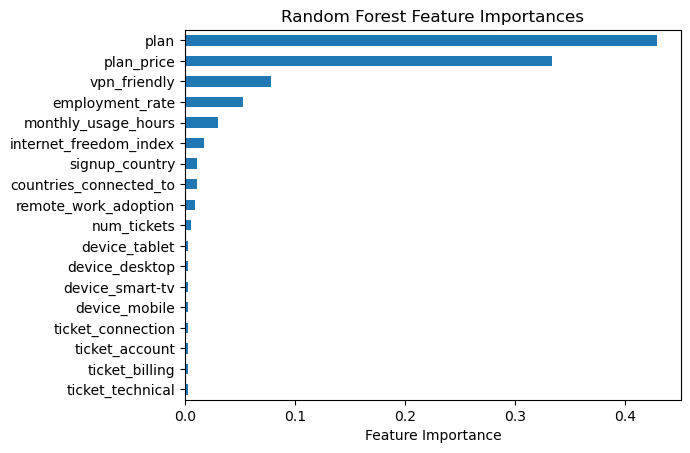

In [39]:
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# plot
feature_importances.sort_values(ascending=True).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.savefig("FeatureImportance.png")
plt.show()

## Calculate the AUC curve

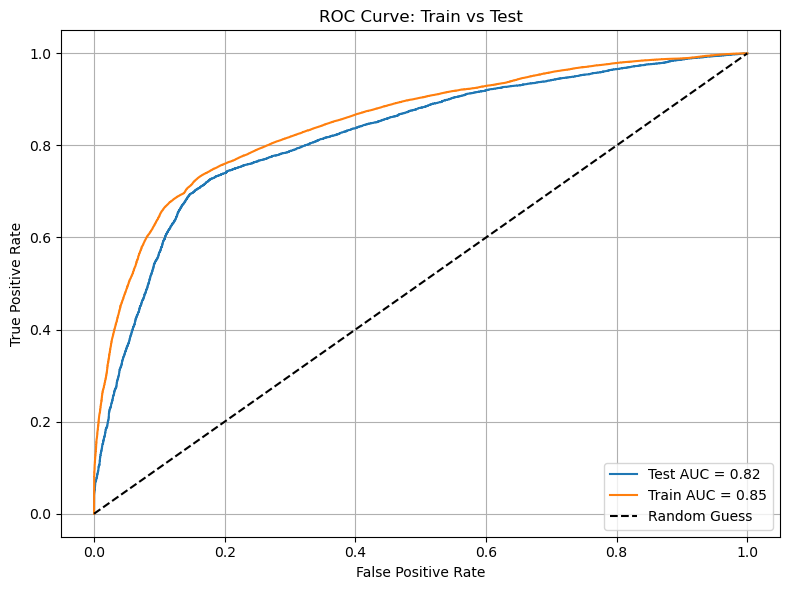

Test AUC = 0.8219
Train AUC = 0.8502


In [15]:
# retrain on best parameters
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=2,
    random_state=42
)

rf.fit(X_train, y_train)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# predict probabilities
y_test_probs = rf.predict_proba(X_test)[:, 1]
y_train_probs = rf.predict_proba(X_train)[:, 1]

# calculate ROC for test
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# calculate ROC for train
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
roc_auc_train = auc(fpr_train, tpr_train)

# plot
plt.figure(figsize=(8,6))
plt.plot(fpr_test, tpr_test, label=f"Test AUC = {roc_auc_test:.2f}")
plt.plot(fpr_train, tpr_train, label=f"Train AUC = {roc_auc_train:.2f}")
plt.plot([0,1], [0,1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve: Train vs Test")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.savefig("AUC.png")
plt.show()
print(f"Test AUC = {roc_auc_test:.4f}")
print(f"Train AUC = {roc_auc_train:.4f}")

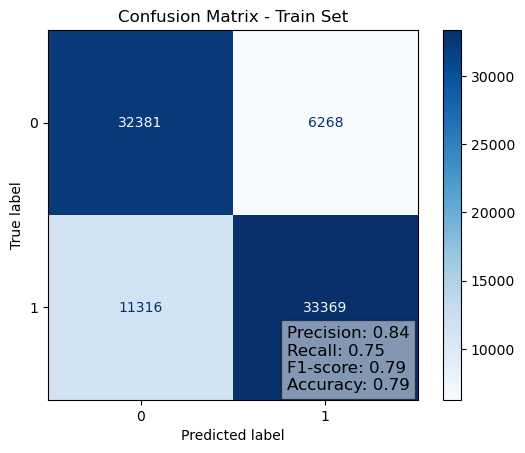

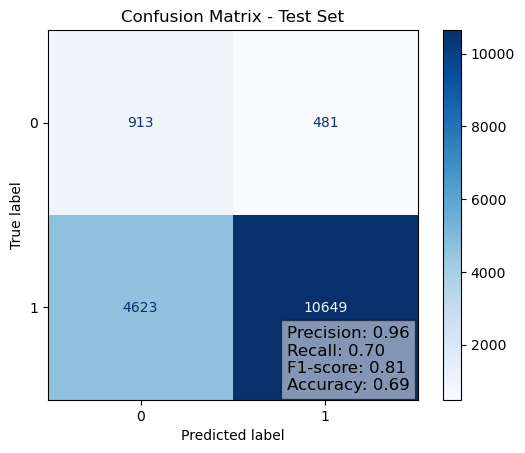

In [37]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score

def plot_confusion_with_metrics(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    accu = accuracy_score(y_true,y_pred)
    # Display metrics on the plot
    textstr = '\n'.join((
        f'Precision: {precision:.2f}',
        f'Recall: {recall:.2f}',
        f'F1-score: {f1:.2f}',
        f'Accuracy: {accu:.2f}',
    ))
    plt.gcf().text(0.54, 0.13, textstr, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.savefig("confusionmatrix.png")
    plt.show()

# Predictions
y_test_pred = rf.predict(X_test)
y_train_pred = rf.predict(X_train)

# Plot with metrics
plot_confusion_with_metrics(y_train, y_train_pred, "Confusion Matrix - Train Set")
plot_confusion_with_metrics(y_test, y_test_pred, "Confusion Matrix - Test Set")


## Time Series test

As the dataset are temporal, it was deemed good to evaluate the models performance
in time intervals and compare how the AUC changes.
    

In [21]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

# sort data by signup_date
merged_df_sorted = merged_df.sort_values("signup_date")

# features & target
X_time = merged_df_sorted[features].copy()
y_time = merged_df_sorted['isActive']

# encode again
X_time['plan'] = le_plan.transform(X_time['plan'])
X_time['signup_country'] = le_country.transform(X_time['signup_country'])
X_time['vpn_friendly'] = pd.to_numeric(X_time['vpn_friendly'], errors='coerce').fillna(0)

# initialize
tscv = TimeSeriesSplit(n_splits=5)
fold = 1
auc_scores = []

for train_idx, test_idx in tscv.split(X_time):
    X_train, X_test = X_time.iloc[train_idx], X_time.iloc[test_idx]
    y_train, y_test = y_time.iloc[train_idx], y_time.iloc[test_idx]
    rf_time = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=2,
        random_state=42
    )
    rf_time.fit(X_train, y_train)
    
    y_test_probs = rf_time.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_test_probs)
    auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.3f}")
    fold += 1

print(f"Average AUC across folds: {np.mean(auc_scores):.3f}")
print(f"Average AUC across folds: {np.std(auc_scores):.3f}")

Fold 1 AUC: 0.823
Fold 2 AUC: 0.781
Fold 3 AUC: 0.831
Fold 4 AUC: 0.778
Fold 5 AUC: 0.716
Average AUC across folds: 0.786
Average AUC across folds: 0.041


## XGBoost test

This is only runnable with the XGBoost library included

In [45]:
%pip install xgboost
#XGBoost Model
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder

# Prepare features and target as before (X, y)
# Label encode categorical features
le_plan = LabelEncoder()
X['plan'] = le_plan.fit_transform(X['plan'])

le_country = LabelEncoder()
X['signup_country'] = le_country.fit_transform(X['signup_country'])

# Split dataset (reuse your previous split indices or do again)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_proba)
#Print AUC score and the Classification report
print(f"XGBoost Test AUC: {auc_score:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

y_test_pred = xgb_model.predict(X_test)
y_train_pred = xgb_model.predict(X_train)

# Plot with metrics
plot_confusion_with_metrics(y_test, y_test_pred, "Confusion Matrix - Test Set")
plot_confusion_with_metrics(y_train, y_train_pred, "Confusion Matrix - Train Set")


Process pip requirements ...



Cannot install xgboost from PyPi. Please make sure to install it from conda-forge or emscripten-forge! e.g. "conda install xgboost"Error: Cannot install xgboost from PyPi. Please make sure to install it from conda-forge or emscripten-forge! e.g. "conda install xgboost"
    at nE (https://jupyter.org/try-jupyter/extensions/@jupyterlite/xeus-extension/static/78.293e4663d411dfd38063.js?v=293e4663d411dfd38063:1:4133567)
    at async rE (https://jupyter.org/try-jupyter/extensions/@jupyterlite/xeus-extension/static/78.293e4663d411dfd38063.js?v=293e4663d411dfd38063:1:4134184)
    at async xE (https://jupyter.org/try-jupyter/extensions/@jupyterlite/xeus-extension/static/78.293e4663d411dfd38063.js?v=293e4663d411dfd38063:1:4136937)
    at async eg.install (https://jupyter.org/try-jupyter/extensions/@jupyterlite/xeus-extension/static/78.293e4663d411dfd38063.js?v=293e4663d411dfd38063:1:4374427)
    at async eg.processMagics (https://jupyter.org/try-jupyter/extensions/@jupyterlite/xeus-extension/st

<class 'ModuleNotFoundError'>: No module named 'xgboost'